# Betrugserkennung an Selbstscan-Kassen
Ein Unternehmen hat Selbstscan Kassen eingeführt und möchte im nächsten Schritt ein Machine Learning Modell trainieren, um BetrügerInnen an den Kassen direkt nach Abschluss des Scan Vorgangs erkennen zu können. Dazu wurde ein Datensatz zusammengestellt, der wichtige Eigenschaften eines Scanvorgangs beinhaltet (wie z.B. Dauer, Artikelanzahl und Gesamtwert) und dazu die Information, ob ein Betrug vorliegt oder nicht. Eine detaillierte Beschreibung der einzelnen Attribute ist nachfolgend im ersten Abschnitt des Notebooks zu finden.
Beim Trainieren der Modelle ist abzuwiegen, worauf der Fokus der Erkennung liegen soll. Entweder kann das Ziel darin liegen, möglichst viele der wahren BetrügerInnen zu entdecken, jedoch werden dabei auch vermehrt ehrliche KundInnen fälschlicherweise des Betrugs beschuldigt (in diesem Fall sollte die True-Positive-Rate bzw. Recall optimiert werden). Das Ziel kann aber auch darin liegen, insgesamt über alle Vorhersagen das bestmögliche Ergebnis zu erzielen (in diesem Fall sollte die Accuracy optimiert werden). Im unternehmerischen Kontext würde das Optimum anhand einer Kosten-Matrix ermittelt werden, darauf wird hier jedoch verzichtet.

**Anmerkung:** Der Datensatz stammt aus einer Lehrveranstaltung im Wirtschaftsinformatik Studium an der Leuphana Universität. Die Datei steht über den folgenden Link zur Verfügung: [Datensatz Download](https://lg4ml.org/wp-content/uploads/2022/01/train.txt)

## Pakete importieren
Zu Beginn werden die wichtigsten Pakete für Data Science Pakete importiert, wie Numpy und Pandas. Dazu kommen grundlegende Bibliotheken zur Visualisierung von Daten, in diesem Fall Matplotlib und Seaborn. Alle weiteren Imports werden im weiteren Verlauf des Notebooks jeweils direkt in der Zelle importiert, in der sie benötigt werden.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline

## 1. Data Exploration
Sobald die Daten vorliegen sieht der nächste Schritt im Data Science Workflow vor, sich einen Überblick über die Daten zu verschaffen und erste Insights zu generieren. Der vorliegende Datensatz ist mit insgesamt 10 Spalten (davon 9 Features bzw. Attribute und Label) zwar noch relativ überschaubar, dennoch sollte man sich die einzelnen Attribute anschauen und unter anderem überprüfen, ob beim Einlesen der Daten alle Datentypen richtig festgelegt wurden oder Änderungen erforderlich sind. Über die `dataset.info()` Methode können diese überprüft werden - zusätzlich gibt es noch indirekt Informationen über fehlende Werte durch den *Non-Null Count* der jeweiligen Spalten.
Eine sehr schnelle Option der Data Exploration stellt das Paket **Pandas Profiling** zur Verfügung. In einem sogenannten *ProfileReport* werden die wichtigsten Eigenschaften der Daten zusammengestellt, darunter fehlende Werte, Verteilungen und Korrelationen zwischen den einzenen Attributen. Die Ergebnisse können entweder als HTML-Datei gespeichert und im Browser oder alternativ direkt im Jupyter Notebook dargestellt werden.

### 1.1 Datensatz einlesen

In [2]:
dataset = pd.read_csv(Path('Data/train.txt'), sep=';')
dataset.head(10)

trustLevel  totalScanTimeInSeconds  grandTotal  lineItemVoids  \
0         NaN                     467       88.48              4   
1         3.0                    1004       58.99              7   
2         5.0                     532       84.79              9   
3         5.0                    1072       12.67              3   
4         3.0                     259       93.75              0   
5         2.0                    1528       47.35              2   
6         NaN                      16       31.91              7   
7         NaN                    1429       47.95              8   
8         NaN                     289       18.66              8   
9         3.0                    1304       30.51              0   

   scansWithoutRegistration  quantityModifications  scannedLineItemsPerSecond  \
0                         8                      4                   0.014989   
1                         6                      1                   0.026892   
2                         3                      4                   0.026316   
3                         4                      1                   0.019590   
4                         7                      0                   0.100386   
5                         9                      5                   0.009817   
6                         7                      4                   1.312500   
7                         1                      3                   0.003499   
8                         4                      0                   0.086505   
9                         7                      3                   0.012270   

   valuePerSecond  lineItemVoidsPerPosition  fraud  
0        0.189465                  0.571429      0  
1        0.058755                  0.259259      0  
2        0.159380                  0.642857      0  
3        0.011819                  0.142857      0  
4        0.361969                  0.000000      0  
5        0.030988                  0.133333      0  
6        1.994375                  0.333333      0  
7        0.033555                  1.600000      0  
8        0.064567                  0.320000      0  
9        0.023397                  0.000000      0

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trustLevel                 174786 non-null  float64
 1   totalScanTimeInSeconds     250000 non-null  int64  
 2   grandTotal                 250000 non-null  float64
 3   lineItemVoids              250000 non-null  int64  
 4   scansWithoutRegistration   250000 non-null  int64  
 5   quantityModifications      250000 non-null  int64  
 6   scannedLineItemsPerSecond  250000 non-null  float64
 7   valuePerSecond             250000 non-null  float64
 8   lineItemVoidsPerPosition   250000 non-null  float64
 9   fraud                      250000 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 19.1 MB


### 1.2 Insights mit Pandas Profiling

In [4]:
from pandas_profiling import ProfileReport
profile_report = ProfileReport(dataset)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Takeaways
- Der Datensatz enthält keine Duplikate
- Im Attribut *TrustLevel* fehlen etwa 30% der Einträge
- Zwischen mehreren Attributen besteht eine hohe Korrelation

## 2. Preprocessing
Der nächste Schritt ist die Vorverarbeitung der Daten, also damit verbunden das Ziel, die Daten für Machine Learning Modelle in eine sinnvolle Form zu bringen. Wie in den Takeaways der Data Exploration festgehalten, fehlen beim Attribut *TrustLevel* etwa 30% der Werte. Fehlende Werte stellen ein Problem für Machine Learning Modelle dar, da sie von den mathematischen Verfahren nicht verarbeitet werden können. Eine Variante bestünde darin, Zeilen mit fehlenden Werten aus dem Datensatz zu entfernen - in diesem Fall würde die Größe des Datensatzes damit jedoch deutlich reduziert werden. Als Alternative dazu können fehlende Werte aufgefüllt werden. In diesem Projekt werden die fehlenden Werte im TrustLevel mithilfe eines KNN-Imputers aufgefüllt bzw. ersetzt. Dieser basiert auf dem KNN-Modell und ermittelt auf Basis der nächsten Nachbarn (also Datenpunkten mit ähnlichen Werten in den verbleibenden Attributen) das fehlende TrustLevel. Dabei wird das Label nicht mit beachtet, da dieses bei späterer Verwendung im laufenden Betrieb nicht vorliegen wird.

In [5]:
# Impute missing values using KNN-Impute
from sklearn.impute import KNNImputer

X, y = dataset.drop(columns=['fraud']), dataset['fraud']

np_imputed = KNNImputer().fit_transform(X)
X_imp = pd.DataFrame(np_imputed, columns=X.columns)
dataset_imp = pd.concat([X_imp, y], axis=1)
dataset_imp.head(10)

trustLevel  totalScanTimeInSeconds  grandTotal  lineItemVoids  \
0         3.4                   467.0       88.48            4.0   
1         3.0                  1004.0       58.99            7.0   
2         5.0                   532.0       84.79            9.0   
3         5.0                  1072.0       12.67            3.0   
4         3.0                   259.0       93.75            0.0   
5         2.0                  1528.0       47.35            2.0   
6         4.6                    16.0       31.91            7.0   
7         3.0                  1429.0       47.95            8.0   
8         4.2                   289.0       18.66            8.0   
9         3.0                  1304.0       30.51            0.0   

   scansWithoutRegistration  quantityModifications  scannedLineItemsPerSecond  \
0                       8.0                    4.0                   0.014989   
1                       6.0                    1.0                   0.026892   
2                       3.0                    4.0                   0.026316   
3                       4.0                    1.0                   0.019590   
4                       7.0                    0.0                   0.100386   
5                       9.0                    5.0                   0.009817   
6                       7.0                    4.0                   1.312500   
7                       1.0                    3.0                   0.003499   
8                       4.0                    0.0                   0.086505   
9                       7.0                    3.0                   0.012270   

   valuePerSecond  lineItemVoidsPerPosition  fraud  
0        0.189465                  0.571429      0  
1        0.058755                  0.259259      0  
2        0.159380                  0.642857      0  
3        0.011819                  0.142857      0  
4        0.361969                  0.000000      0  
5        0.030988                  0.133333      0  
6        1.994375                  0.333333      0  
7        0.033555                  1.600000      0  
8        0.064567                  0.320000      0  
9        0.023397                  0.000000      0

## 3. Machine Learning
Nachdem im Preprocessing der Daten alle fehlenden Werte aufgefüllt werden konnten, kann im nächsten Schritt mit dem Training der Modelle begonnen werden. Zunächst werden einige Funktionen angelegt, die im weiteren Verlauf zur Aufteilung der Daten sowie zur Evaluation der Modelle genutzt werden können. Als Metriken werden Accuracy, Recall & Precision sowie F1-Score genutzt. Die Konfusionsmatrix wird komplett normalisiert, um die Ergebnisse besser zueinander ins Verhältnis setzen zu können.
Zum Unterteilen der Daten in Trainings- und Testdaten wird die `train_test_split` Funktion aus dem Paket Sklearn mit einem *Random State* genutzt, um die Reproduzierbarkeit der Ergebnisse sicherzustellen. Standardmäßig werden 30% der Daten zum Evaluieren der Modelle genutzt, dieser Wert kann beim Funktionsaufruf jedoch angepasst werden.

In [6]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

def print_metrics(y_true, y_predicted):
    print(f'Accuracy Score = {np.round(accuracy_score(y_true, y_predicted), 4)}')
    print(f'Recall Score = {np.round(recall_score(y_true, y_predicted), 4)}')
    print(f'Precision Score = {np.round(precision_score(y_true, y_predicted), 4)}')
    print(f'F1 Score = {np.round(f1_score(y_true, y_predicted), 4)}')
    print()

def plot_confusion_matrix(y_true, y_predicted, title='Confusion Matrix'):
    fig, axs = plt.subplots()
    cm = confusion_matrix(y_true, y_predicted, normalize='all')
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs)
    axs.set(title=title, xlabel='Predicted Label', ylabel='True Label')
    plt.show()

def split_dataset(data: pd.DataFrame, test_size: float = 0.3, random_state: int = 42):
    return train_test_split(data.drop(columns='fraud'), data['fraud'], test_size=test_size, random_state=random_state)


### 3.1 Optimierung auf Accuracy
Wie bereits genannt, können die Modelle nach verschiedenen Aspekten optimiert werden. Im ersten Teil des Machine Learning ist das Ziel, insgesamt die meisten KundInnen richtig zu klassifizieren - daher wird die Accuracy optimiert. Generell gilt jedoch, dass die Accuracy bei stark unbalancierten Datensätzen keine gute Metrik ist, da Modelle schon gute Scores erzielen können, indem immer die Mehrheits-Klasse vorhergesagt wird.

Im Folgenden werden die Daten zunächst für das Training der Modelle vorbereitet. Dazu wird der Datensatz in Trainings- und Testdaten unterteilt. Anschließend können die Feature standardisiert werden, um die Ergebnisse zu optimieren und alle Attribute zu vereinheitlichen.

Danach können die Modelle trainiert werden, in diesem Fall Logistische Regression und ein simples Neuronales Netz. Die Hyperparameter wurden dabei mehr oder weniger unberührt gelassen, lediglich die Anzahl der Neuronen in den versteckten Schichten wurde etwas angepasst. Die Metriken sowie Konfusions-Matrizen sind unter der jeweiligen Codezelle zu finden.

In [7]:
from sklearn.preprocessing import StandardScaler

# Split the dataset
X_train, X_test, y_train, y_test = split_dataset(data=dataset_imp, test_size=0.3)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Accuracy Score = 0.97
Recall Score = 0.4782
Precision Score = 0.8352
F1 Score = 0.6082



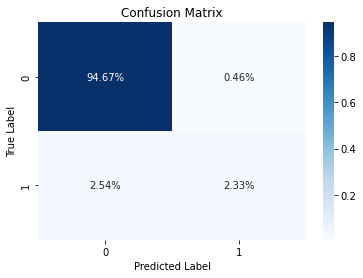

In [10]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(penalty='l2', tol=1e-4, C=1.0)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
print_metrics(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

Accuracy Score = 0.9799
Recall Score = 0.6583
Precision Score = 0.9021
F1 Score = 0.7612



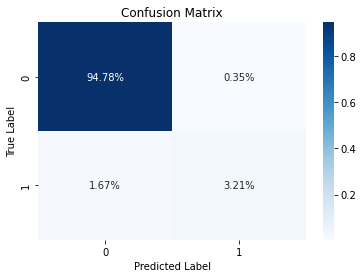

In [12]:
from sklearn.neural_network import MLPClassifier

# Train the model
model = MLPClassifier(hidden_layer_sizes=(18, 9), activation='relu')
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
print_metrics(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

#### Ergebnisse
Sowohl Logistische Regression als auch Neoronales Netz können einen sehr hohen Accuracy Score erzielen, klassifizieren allgemein betrachtet in den allermeisten Fällen richtig (hängt natürlich mit der Class Imbalance zusammen). Die Logistische Regression hat jedoch lediglich einen Recall von knapp unter 0.5 - dies bedeutet, das nur etwas weniger als die Hälfte der BetrügerInnen auch erkannt wird. Das Neuronale Netz schneidet da etwas besser ab und kann etwa zwei Drittel richtig erkennen (Recall von 0.65). Generell lässt sich festhalten, dass das Neuronale Netz etwas bessere Ergebnisse erzielen kann als die Logistische Regression.

### 3.2 Optimierung auf Recall
Im zweiten Teil des Machine Learning werden die Modelle darauf hin optimiert, möglichst viele der BetrügerInnen zu erkennen - also einen möglichst hohen Recall zu erzielen. Theoretische betrachtet könnte der höchstmögliche Recall natürlich erreicht werden, indem einfach immer Betrug vorhergesagt wird. Diese Variante ist jedoch weder aus technischer noch aus betriebswirtschaftlicher Sicht mit Hinblick auf den Kontext sinnvoll und wünschenswert.

Erneut werden die Daten zunächst vorbereitet für das Training der Modelle. Zusätzlich zur Skalierung werden die Trainingsdaten gesamplet, das heißt die Verhältnisse der Daten werden aneinander angeglichen. Dazu werden die Klassen aus dem Paket `Imblearn` in einer sogenannten Pipeline miteinander verknüpft und auf die Daten angewandt. Dabei werden sowohl neue synthetische Datenpunkte für die Klasse Betrug erzeugt, als auch Datenpunkte der Klasse kein Betrug entfernt. Die Ausgabe der zweiten Zelle vergleicht, wie die Anzahl der beiden Klassen durch das Sampling verändert worden ist.

In [31]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Split the dataset
X_train, X_test, y_train, y_test = split_dataset(data=dataset_imp, test_size=0.3)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sample the train data
pipeline = Pipeline(steps=[('o', SMOTE(sampling_strategy=0.5)), ('u', RandomUnderSampler(sampling_strategy=0.8))])
X_train_sampled, y_train_sampled = pipeline.fit_resample(X=X_train_scaled, y=y_train)

In [32]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_sampled, return_counts=True))

(array([0, 1], dtype=int64), array([166729,   8271], dtype=int64))
(array([0, 1], dtype=int64), array([104205,  83364], dtype=int64))


Accuracy Score = 0.8872
Recall Score = 0.8722
Precision Score = 0.2852
F1 Score = 0.4299



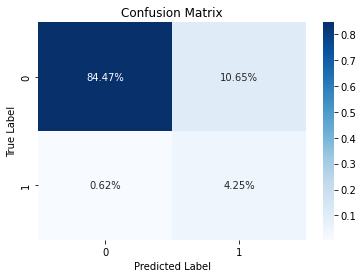

In [33]:
# Train the model
model = LogisticRegression(penalty='l2', tol=1e-4, C=1.0)
model.fit(X_train_sampled, y_train_sampled)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
print_metrics(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

Accuracy Score = 0.9021
Recall Score = 0.9237
Precision Score = 0.3234
F1 Score = 0.4791



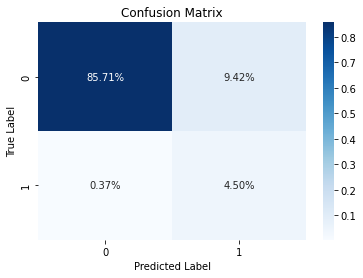

In [34]:
# Train the model
model = MLPClassifier(hidden_layer_sizes=(18, 9), activation='relu')
model.fit(X_train_sampled, y_train_sampled)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
print_metrics(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

#### Ergebnisse
Die Ergebnisse mit Sampling zeigen deutlich, wie der Recall Score angehoben werden konnte. Die Accuracy nimmt zwar insgesamt ab, jedoch können dafür deutlich mehr der tatsächlichen BetrügerInnen richtig erkannt werden - 87% bei der Logistischen Regression und sogar 92% beim Neuronalen Netzwerk. Precision Score und damit auch F1-Score nehmen durch das Sampling deutlich ab, da doch einige Datenpunkte fehlerhaft als Betrug eingestuft werden. Im konkreten Anwendungsfall müsste mit einer Kostenmatrix ein Optimum ermittelt werden, bei dem die Vorhersagen der Modelle die geringsten Kosten verursachen.

## 4. Zusammenfassung
Im ersten Schritt konnten mit Pandas Profiling erste Insights aus dem Datensatz gewonnen werden. Dabei fiel unter anderem auf, dass in der Spalte *TrustLevel* fehlende Werte vorhanden sind. Diese konnten im Preprocessing durch KNN-Imputing auf Basis der weiteren Daten gefüllt werden. Beim Machine Learning wurden jeweils Logistische Regression und ein simples Neuronales Netz trainiert, dabei einmal ohne und einmal mit Sampling der Daten. Das Sampling der Daten führt dazu, dass die Modelle einen höheren Anteil der BetrügerInnen auch als diese erkennen - gleichermaßen werden aber auch mehr Datenpunkte fehlerhaft als Betrug eingestuft. Aus unternehmerischer Sicht muss über die Berechnung der Verluste in beiden Fällen abgewogen werden, welches der Modelle optimaler ist und zum Einsatz kommen soll.

Der nächste Schritt nach Auswahl eines passenden Modells wäre das Deployment, also die Implementierung des Modells in die Prozesse des Unternehmens an den Selbstscann-Kassen. Dabei gilt es zu beachten, in welcher Form die Daten von den Kassen aufgezeichnet werden und wie sie optimalerweise an das Modell weitergereicht werden können. Neben der reinen technischen Realisierung muss das Unternehmen auch sicherstellen, dass die MitarbeiterInnen an den Kassen potenzielle BetrügerInnen kontrollieren und dem System Feedback zur Vorhersage geben können, um langfristig die Qualität der Betrugserkennung zu verbessern.